### Importing Libraries

In [1]:
import cv2
import numpy as np
import imageio as iio
from skimage import io, color
from matplotlib import pyplot as plt

### Reading Image and make a Lab version

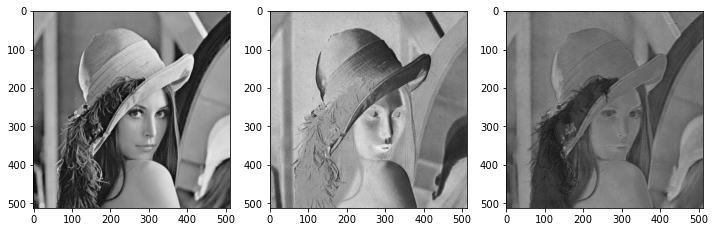

In [2]:
img = iio.imread("im05.png")
#img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
img = color.rgb2lab(img) # put it to Lab version
plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.imshow(img[:,:,0],cmap='gray');
plt.subplot(1,3,2)
plt.imshow(img[:,:,1],cmap='gray');
plt.subplot(1,3,3)
plt.imshow(img[:,:,2],cmap='gray');

#### Function for part1) first I put points in the middle of each section and then by get_least_grad I move the point with least gradient 

In [3]:
def set_centers(img,k=64,size=5):
    sk = int(np.sqrt(k))
    gray = cv2.cvtColor(color.lab2rgb(img).astype('uint8'), cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, 0)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, 0)
    grad = cv2.addWeighted(cv2.convertScaleAbs(grad_x), 0.5, cv2.convertScaleAbs(grad_y), 0.5, 0)
    out = np.zeros((img.shape[0],img.shape[1]))
    array = []
    for i in range(sk):
        for j in range(sk):
            x = int((i+0.5)*(out.shape[0]/sk))
            y = int((j+0.5)*(out.shape[1]/sk))
            dx,dy = get_lesat_grad(grad[x-size//2:x+size//2+1,y-size//2:y+size//2+1])
            #out[x:x+5,y:y+5] = 1
            x = x+dx
            y = y+dy
            out[x,y] = 1
            array.append((x,y))
    return array
def get_lesat_grad(grad,size=5):
    min_loc = np.array(np.where(grad==np.min(grad))).flatten()
    return min_loc[0],min_loc[1]
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*256
#plt.imshow(set_centers(img,k=256),cmap='gray');
#print(sum(sum(set_centers(img,k=101))))
#print(set_centers(img)[0][1])

#### Part2) set label calculates super pixels and returns l(which is labels) and also centers
##### get_distance calculates distance from a center to get least distance for assigning super pixels
##### new_centers simply calculates new center location by averaging pixels in that section

In [4]:
def set_label(img,k=64):
    N = img.shape[0]*img.shape[1]
    s = int(np.sqrt(N/k))
    centers = set_centers(img,k=k)
    l = -np.ones((img.shape[0],img.shape[1])) #-1 is initial label
    d = 10**10*np.ones(l.shape) #infinity
    error = 13 # to do this 13-10 times :)
    while(error>10):
        #print(error)
        for i_k in range(k): #each super pixel
            for i in range(2*s): # 2s x 2s neigbors
                for j in range(2*s):
                    x = centers[i_k][0]+i-s
                    y = centers[i_k][1]+j-s
                    if x<img.shape[0] and y<img.shape[1]:
                        D = get_distance(img,x,y,centers[i_k][0],centers[i_k][1])
                        if D<d[x,y] : #if distance was lower add point to this super pixel
                            d[x,y] = D
                            l[x,y] = i_k # set label to that center
        error -= 1
        centers = new_centers(l,k=k) #get new centers from average of that section
    return l, centers
def get_distance(img,x,y,ck_x,ck_y,alpha=0.7):
    l,a,b = img[x,y,0],img[x,y,1],img[x,y,2]
    lk,ak,bk = img[ck_x,ck_y,0],img[ck_x,ck_y,1],img[ck_x,ck_y,2]
    d_lab = np.sqrt((l-lk)**2+(a-ak)**2+(b-bk)**2)
    d_xy = np.sqrt((x-ck_x)**2+(y-ck_y)**2)
    return d_lab+alpha*d_xy
def new_centers(l,k=64): #update center by average of that section
    x = np.zeros(k)
    y = np.zeros(k)
    n = np.zeros(k)
    for i in range(l.shape[0]):
        for j in range(l.shape[1]):
            x[int(l[i,j])] += i
            y[int(l[i,j])] += j
            n[int(l[i,j])] += 1
    centers = []
    for i_k in range(k):
        centers.append((int(x[i_k]/n[i_k]),int(y[i_k]/n[i_k]))) #average location
    return centers

#### Here you get labels by set_label function and set the color to average color in the section and return final image and labeled matrix

In [5]:
def super_pixel(img,k=64):
    l, centers = set_label(img,k=k) #get labeled
    l_pixel = np.zeros(k)
    a = np.zeros(k)
    b = np.zeros(k)
    n = np.zeros(k)
    for i in range(l.shape[0]):
        for j in range(l.shape[1]):
            l_pixel[int(l[i,j])] += img[i,j,0]
            a[int(l[i,j])] += img[i,j,1]
            b[int(l[i,j])] += img[i,j,2]
            n[int(l[i,j])] += 1
    final = np.zeros(img.shape) # set average color
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            final[i,j,0] = int(l_pixel[int(l[i,j])]/n[int(l[i,j])])
            final[i,j,1] = int(a[int(l[i,j])]/n[int(l[i,j])])
            final[i,j,2] = int(b[int(l[i,j])]/n[int(l[i,j])])
    return final, l

### super pixel calculation

In [6]:
super64, l64 = super_pixel(img,k = 64)
print(".")
super256, l256 = super_pixel(img,k = 256)
print(".")
super1024, l1024 = super_pixel(img,k = 1024)
print(".")
super4096,l4096 = super_pixel(img,k = 4096)

.
.
.


In [12]:
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

iio.imwrite("q4/res14-labels.jpg",scale(l64).astype('uint8'))
iio.imwrite("q4/res15-labels.jpg",scale(l256).astype('uint8'))
iio.imwrite("q4/res16-labels.jpg",scale(l1024).astype('uint8'))
iio.imwrite("q4/res17-labels.jpg",scale(l4096).astype('uint8'))

#### get edges to set clusters border

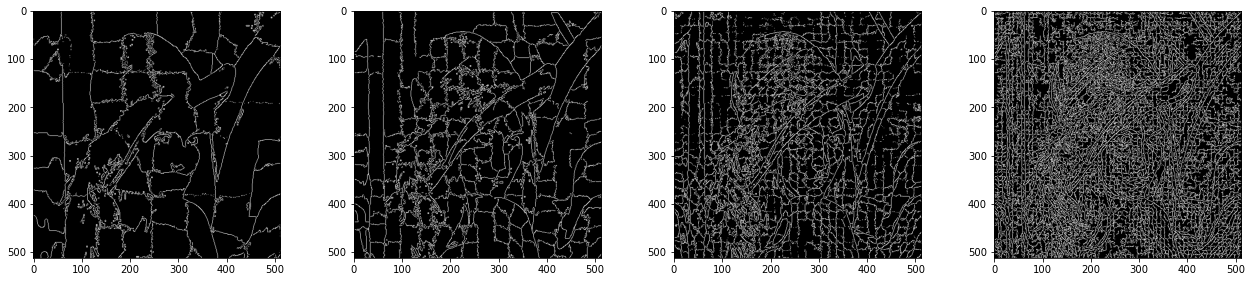

In [39]:
edges64 = cv2.Canny(image=super64.astype('uint8'), threshold1=12, threshold2=15) # Canny Edge 
edges256 = cv2.Canny(image=super256.astype('uint8'), threshold1=10, threshold2=14)
edges1024 = cv2.Canny(image=super1024.astype('uint8'), threshold1=8, threshold2=10)
edges4096 = cv2.Canny(image=super4096.astype('uint8'), threshold1=4, threshold2=7)

plt.figure(figsize=(22,10))
plt.subplot(2,4,1)
plt.imshow((edges64),cmap='gray');
plt.subplot(2,4,2)
plt.imshow((edges256),cmap='gray');
plt.subplot(2,4,3)
plt.imshow((edges1024),cmap='gray');
plt.subplot(2,4,4)
plt.imshow((edges4096),cmap='gray');

iio.imwrite("q4/res18-clusters.jpg",edges64)
iio.imwrite("q4/res19-clusters.jpg",edges256)
iio.imwrite("q4/res20-clusters.jpg",edges1024)
iio.imwrite("q4/res21-clusters.jpg",edges4096)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


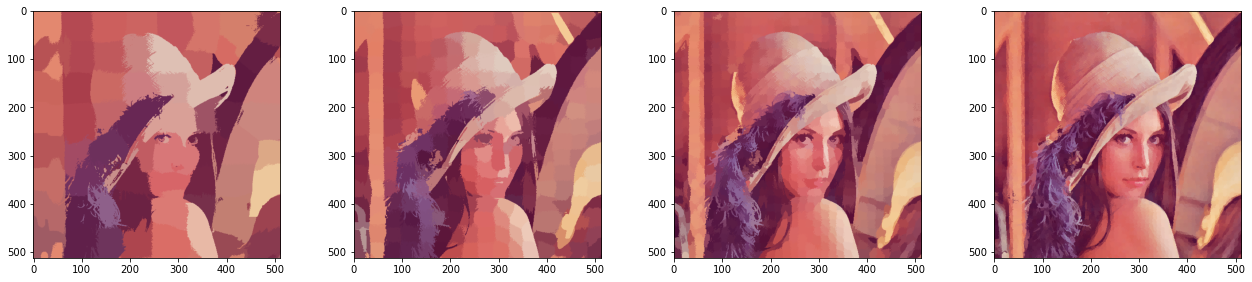

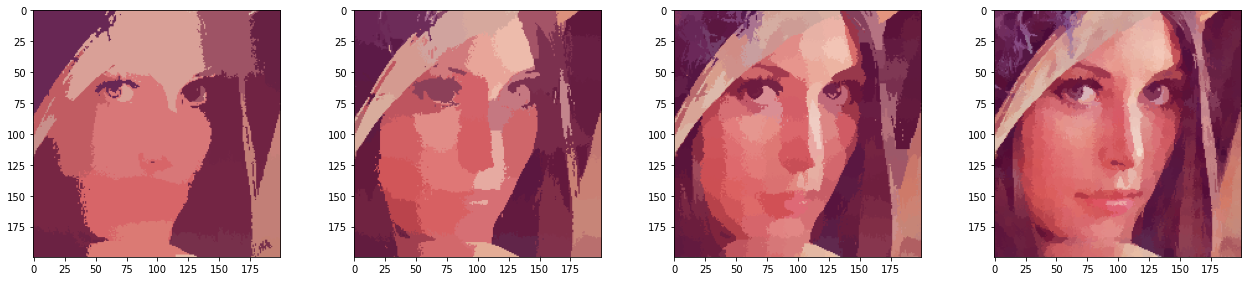

In [45]:
plt.figure(figsize=(22,10))
plt.subplot(2,4,1)
plt.imshow(color.lab2rgb(super64),cmap='gray');
plt.subplot(2,4,2)
plt.imshow(color.lab2rgb(super256),cmap='gray');
plt.subplot(2,4,3)
plt.imshow(color.lab2rgb(super1024),cmap='gray');
plt.subplot(2,4,4)
plt.imshow(color.lab2rgb(super4096),cmap='gray');
#iio.imwrite("q4/super.jpg",color.lab2rgb(super256))
plt.figure(figsize=(22,10))
plt.subplot(2,4,5)
plt.imshow(color.lab2rgb(super64)[200:400,200:400],cmap='gray');
plt.subplot(2,4,6)
plt.imshow(color.lab2rgb(super256)[200:400,200:400],cmap='gray');
plt.subplot(2,4,7)
plt.imshow(color.lab2rgb(super1024)[200:400,200:400],cmap='gray');
plt.subplot(2,4,8)
plt.imshow(color.lab2rgb(super4096)[200:400,200:400],cmap='gray');

iio.imwrite("q4/res22-superpixel.jpg",color.lab2rgb(super64))
iio.imwrite("q4/res23-superpixel.jpg",color.lab2rgb(super256))
iio.imwrite("q4/res24-superpixel.jpg",color.lab2rgb(super1024))
iio.imwrite("q4/res25-superpixel.jpg",color.lab2rgb(super4096))